In [71]:
import numpy as np 
import matplotlib.pyplot as plt
import math

In [72]:
class Value:
    def __init__(self, data, op='', prev = None, grad = 0.0, name = ''):
        self.data = data 
        self._op = op
        self._prev = [] if prev is None else prev
        self._grad = 0.0
        self.name = name
    
    def __add__(self, other):
        if( isinstance(other, Value)):  
            return Value(self.data + other.data, op='+', prev=[self, other], name=f"({self.name} + {other.name})")
        else:
            return Value(self.data + other, op='+', prev=[self, other], name=f"({self.name} + {other})")
    
    def __radd__(self, other):
        if( isinstance(other, Value)):  
            return Value(self.data + other.data, op='+', prev=[self, other], name=f"({self.name} + {other.name})")
        else:
            return Value(self.data + other, op='+', prev=[self, other], name=f"({self.name} + {other})")
    
    def __mul__(self, other):
        if( isinstance(other, Value)):  
            return Value(self.data * other.data, op='*', prev=[self, other], name=f"({self.name} * {other.name})")
        else:
            return Value(self.data * other, op='*', prev=[self, other], name=f"({self.name} * {other})")
    
    def __rmul__(self, other):
        if( isinstance(other, Value)):      
            return Value(self.data * other.data, op='*!', prev=[self, other], name=f"({self.name} * {other.name})")
        else:
            return Value(self.data * other, op='*!', prev=[self, other], name=f"({self.name} * {other})")
    
    def __pow__(self, other):
        if( isinstance(other, Value)):      
            return Value(self.data ** other.data, op='**', prev=[self, other], name=f"({self.name} ** {other.name})")
        else:
            return Value(self.data ** other, op='**', prev=[self, other], name=f"({self.name} ** {other})")
    def __rpow__(self, other):
        if( isinstance(other, Value)):      
            return Value(other.data ** self.data, op='**', prev=[other, self], name=f"({other.name} ** {self.name})")
        else:
            return Value(other ** self.data, op='**', prev=[other, self], name=f"({other} ** {self.name})")
    
    def __truediv__(self, other):
        if( isinstance(other, Value)):      
            return Value(self.data / other.data, op='/', prev=[self, other], name=f"({self.name} / {other.name})")
        else:
            return Value(self.data / other, op='/', prev=[self, other], name=f"({self.name} / {other})")
    
    def __rtruediv__(self, other):
        if( isinstance(other, Value)):      
            return Value(other.data / self.data, op='/', prev=[self, other], name=f"({other.name} / {self.name})")
        else:
            return Value(other / self.data, op='/', prev=[self, other], name=f"({other} / {self.name})")
    
    def __neg__(self):
        return Value(-self.data, op='-', prev=[self], name=f"(-{self.name})")
    
    def __sub__(self, other):
        if( isinstance(other, Value)):      
            return Value(self.data - other.data, op='-', prev=[self, other], name=f"({self.name} - {other.name})")
        else:
            return Value(self.data - other, op='-', prev=[self, other], name=f"({self.name} - {other})")
    
    def __rsub__(self, other):
        if( isinstance(other, Value)):      
            return Value(other.data - self.data, op='-', prev=[other, self], name=f"({other.name} - {self.name})")
        else:
            return Value(other - self.data, op='-', prev=[other, self], name=f"({other} - {self.name})")
    
    def __repr__(self):
        return f"Value(data={self.data}, op={self._op},  grad={self._grad}, name={self.name})"
    

    def tanh(self):
        a = math.exp(2 * self.data) - 1
        b = math.exp(2 * self.data) + 1
        c= Value(a/b, op='tanh', prev=[self], name=f"tanh({self.name})")
        return c
    
    def zero_grad(self):
        self._grad = 0.0
        for prev_node in self._prev:
            if isinstance(prev_node, Value):
                prev_node.zero_grad()
    
    def backward(self, child_node = None):
        if child_node is None:
            self._grad = 1.0
            for prev_node in self._prev:
                if isinstance(prev_node, Value):
                    prev_node.backward(self)
                
            return 
        
        child_op = child_node._op 
        child_grad = child_node._grad 

        if child_op == '+':
            self._grad += child_grad 
        elif child_op == '*' or child_op == '*!':
            child_prev_nodes = child_node._prev
            if isinstance(child_prev_nodes[0], Value):
                if self == child_prev_nodes[0]:
                    if isinstance(child_prev_nodes[1], Value):  
                        self._grad += child_grad * child_prev_nodes[1].data 
                    else:
                        self._grad += child_grad * child_prev_nodes[1]
            if isinstance(child_prev_nodes[1], Value):
                if self == child_prev_nodes[1]:
                    if isinstance(child_prev_nodes[0], Value):
                        self._grad += child_grad * child_prev_nodes[0].data 
                    else:
                        self._grad += child_grad * child_prev_nodes[0]
        elif child_op == '-':
            child_prev_nodes = child_node._prev
            if isinstance(child_prev_nodes[0], Value):
                if self == child_prev_nodes[0]:
                    self._grad += child_grad 
            if isinstance(child_prev_nodes[1], Value):
                if self == child_prev_nodes[1]:
                    self._grad -= child_grad 
        elif child_op == '**':
            child_prev_nodes = child_node._prev
            if self == child_prev_nodes[0]:
                if isinstance(child_prev_nodes[1], Value):
                    self._grad += child_grad * child_prev_nodes[1].data * (self.data ** (child_prev_nodes[1].data - 1))
                else:
                    self._grad += child_grad * child_prev_nodes[1] * (self.data ** (child_prev_nodes[1] - 1))
            if self == child_prev_nodes[1]:
                if isinstance(child_prev_nodes[0], Value):
                    self._grad += child_grad * child_node.data * math.log(child_prev_nodes[0].data)
                else:
                    self._grad += child_grad * child_node.data * math.log(child_prev_nodes[0])
        
        elif child_op == 'tanh':
            self._grad += child_grad * (1 - child_node.data ** 2)
            

            
        for prev_node in self._prev:
            if isinstance(prev_node, Value):
                prev_node.backward(self)


In [73]:
a = Value(10)
b = Value(20)
c = a + b
print(c)

d = a * b
print(d)

e = a ** b
print(e)

f = a / b
print(f)

Value(data=30, op=+,  grad=0.0, name=( + ))
Value(data=200, op=*,  grad=0.0, name=( * ))
Value(data=100000000000000000000, op=**,  grad=0.0, name=( ** ))
Value(data=0.5, op=/,  grad=0.0, name=( / ))


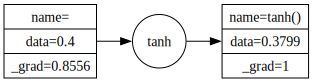

In [74]:
from graphviz import Digraph
from graphviz.backend import ExecutableNotFound

def trace(root):
    """Trace the graph starting from root, returning all nodes and edges."""
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in getattr(v, '_prev', []):
                if isinstance(child, Value):
                    edges.add((child, v))
                    build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """Draws a computation graph of Value objects using graphviz, showing data and _grad."""
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) 

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # Node for value, now showing both data and _grad
        grad = getattr(n, '_grad', None)
        grad_str = f"{grad:.4g}" if grad is not None else "None"
        name_str = getattr(n, 'name', None)
        if name_str is not None:
            label = f"name={name_str}|data={n.data:.4g}|_grad={grad_str}"
        else:
            label = f"data={n.data:.4g}|_grad={grad_str}"
        dot.node(
            name=uid, 
            label=label, 
            shape='record'
        )
        # If operation, add op node
        if hasattr(n, '_op') and n._op:
            op_uid = uid + n._op
            dot.node(name=op_uid, label=n._op, shape='circle')
            dot.edge(op_uid, uid)
    for n1, n2 in edges:
        if hasattr(n2, '_op') and n2._op:
            dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        else:
            dot.edge(str(id(n1)), str(id(n2)))
    return dot

def visualize_function_operations(output, show_error_message=True):
    """
    Visualizes the computation graph of a function using graphviz.
    Assumes the function returns a Value object with a ._prev attribute for dependencies.
    If Graphviz executables are not found, prints a helpful error message.
    """
    
    try:
        dot = draw_dot(output)
        return dot  # In Jupyter, returning dot will display it
    except ExecutableNotFound as e:
        if show_error_message:
            from IPython.display import display, HTML
            display(HTML(
                "<div style='color: red; font-weight: bold;'>"
                "Graphviz executable not found. Please install Graphviz and ensure 'dot' is on your system PATH.<br>"
                "See: <a href='https://graphviz.gitlab.io/download/' target='_blank'>Graphviz Download</a><br>"
                "Error: {}</div>".format(str(e))
            ))
        else:
            print("Graphviz executable not found. Please install Graphviz and ensure 'dot' is on your system PATH.")
        return None

# Example usage:
def example_func(x, y):
    return (Value(0.4)).tanh()

x = Value(3, name='x')
y = Value(2, name='y')
output = example_func(x, y)
output.backward()
visualize_function_operations(output)


In [75]:
import random
class Neuron:
    def __init__(self, input_dim, activation_function="tanh"):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(input_dim)]
        self.b = Value(random.uniform(-1, 1))
        self.activation_function = activation_function

    def __call__(self, x):
        if self.activation_function == "tanh":
            return (sum(w * x for w, x in zip(self.w, x)) + self.b).tanh()
    

    def parameters(self):
        return self.w + [self.b]
    
    def __repr__(self):
        return f"Neuron(w={self.w}, b={self.b})"
    
    
    
    

In [76]:
neuron = Neuron(4)
x = [Value(random.uniform(-1, 1)) for _ in range(4)]

neuron(x)

Value(data=0.776447996853833, op=tanh,  grad=0.0, name=tanh((((((( * ) + 0) + ( * )) + ( * )) + ( * )) + )))

In [77]:
y = Value(1, name='y')
loss = (neuron(x) - y) ** 2
loss.zero_grad()
loss.backward()


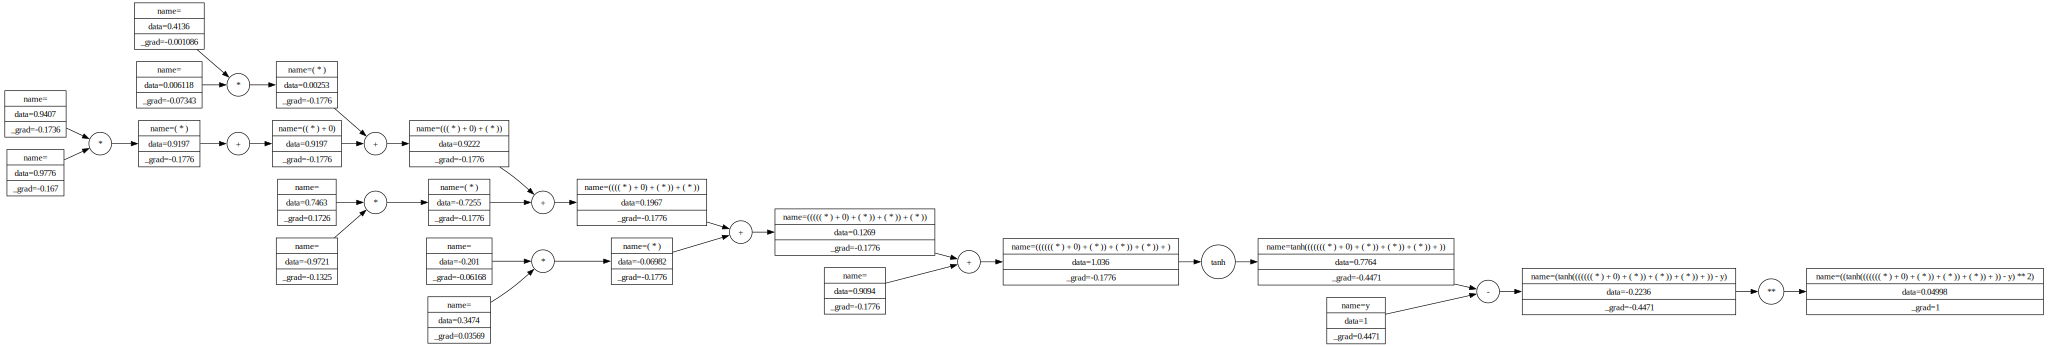

In [78]:

visualize_function_operations(loss)

In [79]:
class Layer:
    def __init__(self, input_dim, output_dim, activation_function="tanh"):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation_function = activation_function
        self.neurons = [Neuron(input_dim, activation_function) for _ in range(output_dim)]

    def __call__(self, x):
        return [neuron(x) for neuron in self.neurons]
    
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]
    
    

In [80]:
layer = Layer(4, 1, "tanh")
x = [Value(random.uniform(-1, 1)) for _ in range(4)]
output = layer(x)
loss = (output[0] - 1) ** 2
loss.zero_grad()
loss.backward()


In [ ]:
class NeuralNetwork:
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.layers = [Layer(input_dim, 8, activation_function = "tanh") ,
                       Layer(8, 4, activation_function = "tanh") ,
                       Layer(4, 2, activation_function = "tanh") ,
                       Layer(2, 1, activation_function = "tanh")]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [ ]:
nn = NeuralNetwork(4, 1)
x = [[Value(random.uniform(-1, 1)) for _ in range(4)] for _ in range(128)]
y = [Value(random.uniform(-1, 1)) for _ in range(128)]
for i in range(1000):
    loss = Value(0)
    for j in range(128):
        output = nn(x[j])
        loss += (output[0] - y[j]) ** 2
        # if j==0:
        #     print("x[0] = ", x[j], "y[0] = ", y[j])
        #     print("output[0] = ", output[0])
    loss.backward()
    for param in nn.parameters():
        param.data -= 0.001 * param._grad
    print(loss.data)
    loss.zero_grad()
    




40.514273007602284


OverflowError: math range error